In [1]:
import os
import random

# import imutils
# from PIL import Image

import shutil
import hashlib
import numpy as np

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [2]:
random.seed(42)

### Setting file directories
Run only the corresponding cell for each dataset

In [21]:
# RUN THIS CELL TO PRE-PROCESS DATASET 1 

dataset = "./dataset1/brain_tumor_dataset"
dataset_pp = dataset+"_pp"
class_labels = [filename for filename in os.listdir(dataset)]
print(f"Classes : {class_labels}")

limit_dataset = False
limit_percentage = 1

Classes : ['no', 'yes']


In [3]:
# RUN THIS CELL TO PRE-PROCESS DATASET 2

dataset = "dataset2/Brain Tumor Data Set/Brain Tumor Data Set"
dataset_pp = dataset+"_pp"
class_labels = [filename for filename in os.listdir(dataset)]
print(f"Classes : {class_labels}")

limit_dataset = True
limit_percentage = 0.06

Classes : ['Brain Tumor', 'Healthy']


## Preprocessing

### Finding and deleting duplicate files in class directories

In [4]:
def find_unique_files(directory):
    # checks for duplicate files in a directory
    # directory : directory to check
    
    file_hash_map = {}
    uniques = []
    duplicates = []

    all_files = os.listdir(directory)

    for filename in all_files:
        filepath = os.path.join(directory, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(filepath):
            # Calculate hash
            with open(filepath, 'rb') as file:
                file_hash = hashlib.sha256(file.read()).hexdigest()

            # Check if the hash already found
            if not file_hash in file_hash_map:
                file_hash_map[file_hash] = filepath
                uniques.append(filename)
            else:
                duplicates.append([filepath,file_hash_map[file_hash]])
    
    return uniques, len(all_files), duplicates

In [5]:
u_map = {}
d_map = {}
for cl in class_labels:
    print(f"Class : {cl}")
    u, t, d = find_unique_files(dataset+"/"+cl)
    print(f"{len(u)} unique files out of a total of {t} files" )
    u_map[cl] = u
    d_map[cl] = d
    print('-------------------------------------------')

if limit_dataset:
    print(f"Limiting number of files in each class to {limit_percentage:.1%} of unique files")
    for key, value in u_map.items():
        numfiles2select = int(len(value) * limit_percentage)
        print(f"Selected {numfiles2select} files of class : {key}")
        u_map[key] = sorted(random.sample(value, numfiles2select))

Class : Brain Tumor
2304 unique files out of a total of 2513 files
-------------------------------------------
Class : Healthy
1752 unique files out of a total of 2087 files
-------------------------------------------
Limiting number of files in each class to 6.0% of unique files
Selected 138 files of class : Brain Tumor
Selected 105 files of class : Healthy


Show examples of duplicate images found

Class : Brain Tumor
duplicates : 209
----------------------


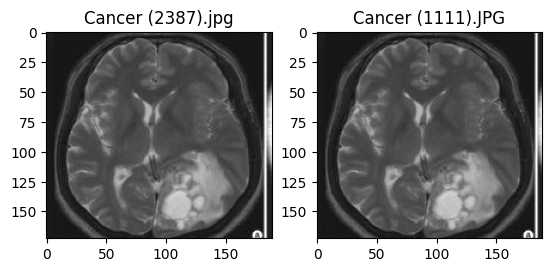

Class : Healthy
duplicates : 335
----------------------


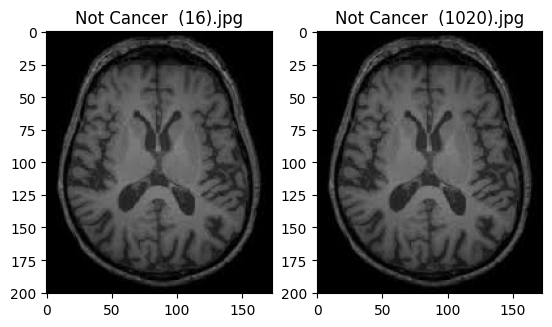

In [6]:
# will plot 1 duplicate example per class
for cl in class_labels:
    print(f"Class : {cl}")
    cl_d = len(d_map[cl])
    print(f"duplicates : {cl_d}")
    print('----------------------')
    if cl_d > 0:
        r = random.randint(0, cl_d-1)
        i0 = cv2.imread(d_map[cl][r][0])
        i1 = cv2.imread(d_map[cl][r][1])
        plt.subplot(1, 2, 1)
        plt.imshow(i0)  # Display the first image in the first subplot
        plt.title(os.path.basename(d_map[cl][r][0]))

        plt.subplot(1, 2, 2)
        plt.imshow(i1)  # Display the second image in the second subplot
        plt.title(os.path.basename(d_map[cl][r][1]))

        plt.show()  # Show the plot


### Vizualization of dataset class composition

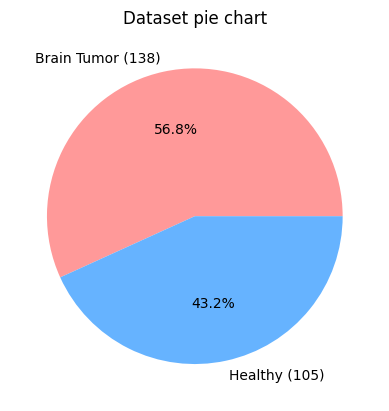

In [7]:
colors = ['red', 'blue']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#ffcc99', '#c2f0f0', '#ff6666', '#c2c2c2']

sizes = []
for key, value in u_map.items():
    sizes.append(len(value))

# # Generate labels with count and percentage
pie_labels = [f"{label} ({count})" for label, count in zip(class_labels, sizes)]

plt.pie(sizes, labels=pie_labels, colors=colors, autopct='%1.1f%%')
plt.title('Dataset pie chart')
plt.show()

### Normalization

In [26]:
def remove_white_bars(img0):

    height, width, _ = img0.shape

    p1 = (0, 0)
    p2 = (width - 1, height - 1)

    # Define the color to fill (black color in BGR format)
    fill_color = (0, 0, 0)

    # Create a mask with the same dimensions as the image
    mask = np.zeros((height+2, width+2), dtype=np.uint8) 

    # Use the flood fill algorithm to fill the region starting from (0, 0) with black color
    cv2.floodFill(img0, mask, p1, fill_color)
    cv2.floodFill(img0, mask, p2, fill_color)

    return img0

def img_bbox(img0):
  if img0.ndim == 3:
    img1 = np.sum(img0, axis = 2)
  else:
    img1 = img0

  p = np.sum(img1, axis = 1)
  p_T = np.where(p != 0)[0][0]
  p_B = np.where(p != 0)[0][-1]

  p = np.sum(img1, axis = 0)
  p_L = np.where(p != 0)[0][0]
  P_R = np.where(p != 0)[0][-1]

  if img0.ndim == 3:
    img1 = img0[p_T:p_B, p_L:P_R,:]
  else:
    img1 = img0[p_T:p_B, p_L:P_R]

  return img1

def makedir(dir2make):
    if os.path.exists(dir2make):
        print(f"'{dir2make}' already exists, it will be deleted and recreated")
        shutil.rmtree(dir2make)
    
    os.makedirs(dir2make)
    print(f"{dir2make} created")

In [32]:
random.seed(42)

sets = ['Train', 'Test']
set_filenames = [[], []]

IMG_SIZE = (224,224)
test_ratio = 0.2

for ii , cl in enumerate(class_labels):
    print ('----------------')
    print(f"{ii} | class : {cl}")
    
    for jj in sets:
        makedir(dataset_pp + "/" + jj + "/" + cl)
    
    set_filenames[0], set_filenames[1] = train_test_split(u_map[cl], test_size=test_ratio, random_state=42)

    for sn, sf in enumerate(set_filenames):
        
        for jj in sf:
            img_path = dataset + "/" + cl + "/" + jj
            save_path = dataset_pp + "/" + sets[sn] + "/" + cl + "/" + jj
        
            img = cv2.imread(img_path)
            img_pp = remove_white_bars(img)
            img_pp = img_bbox(img_pp)
            # img_pp = cv2.resize(img_pp, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            
            cv2.imwrite(save_path, img_pp)


----------------
0 | class : Brain Tumor
dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp/Train/Brain Tumor created
dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp/Test/Brain Tumor created
----------------
1 | class : Healthy
dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp/Train/Healthy created
dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp/Test/Healthy created


# END